<a href="https://colab.research.google.com/github/andremanhas/TechChallenge4/blob/main/preco_petroleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Preço do Petróleo Brent





In [1]:
!pip install psycopg2-binary


In [2]:
pip install pmdarima

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import psycopg2

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Métricas de avaliação dos modelos

In [5]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## 1. Coleta de Dados

In [6]:
# Leitura dos dados
dados = pd.read_excel("ipeadata.xlsx")

# Exiba o DataFrame
print(dados.head())

         data  preco
0  20/05/1987  18.63
1  21/05/1987  18.45
2  22/05/1987  18.55
3  25/05/1987  18.60
4  26/05/1987  18.63


In [7]:
print(dados.tail())

             data  preco
11282  22/10/2024  75.59
11283  23/10/2024  74.68
11284  24/10/2024  74.27
11285  25/10/2024  75.62
11286  28/10/2024  71.87


In [8]:
# Converter a coluna de data para o formato datetime
dados['data'] = pd.to_datetime(dados['data'], format='%d/%m/%Y')

# Definir as datas A e B
#data_A = '01/07/2018'
#data_B = '30/06/2024'

# Filtrar o DataFrame entre as datas A e B
#filtro = (dados['data'] >= data_A) & (dados['data'] <= data_B)
#dados_filtrados = dados[filtro]

#print(dados_filtrados)

dados_filtrados = dados

## 2. Análise Exploratória dos Dados

### Visualização dos Dados

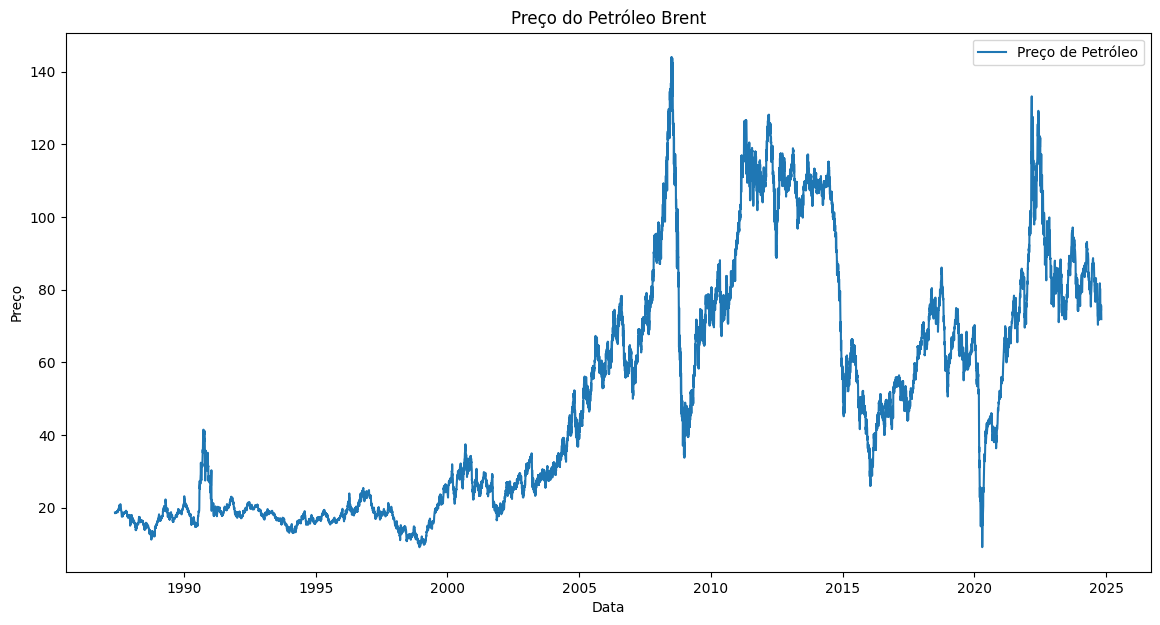

In [9]:
# Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(dados_filtrados["data"], dados_filtrados["preco"], label="Preço de Petróleo")
plt.title("Preço do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

### Decomposição da Série Temporal

In [10]:
result = seasonal_decompose(dados_filtrados["preco"], model="multiplicative", period=100)

<Axes: >

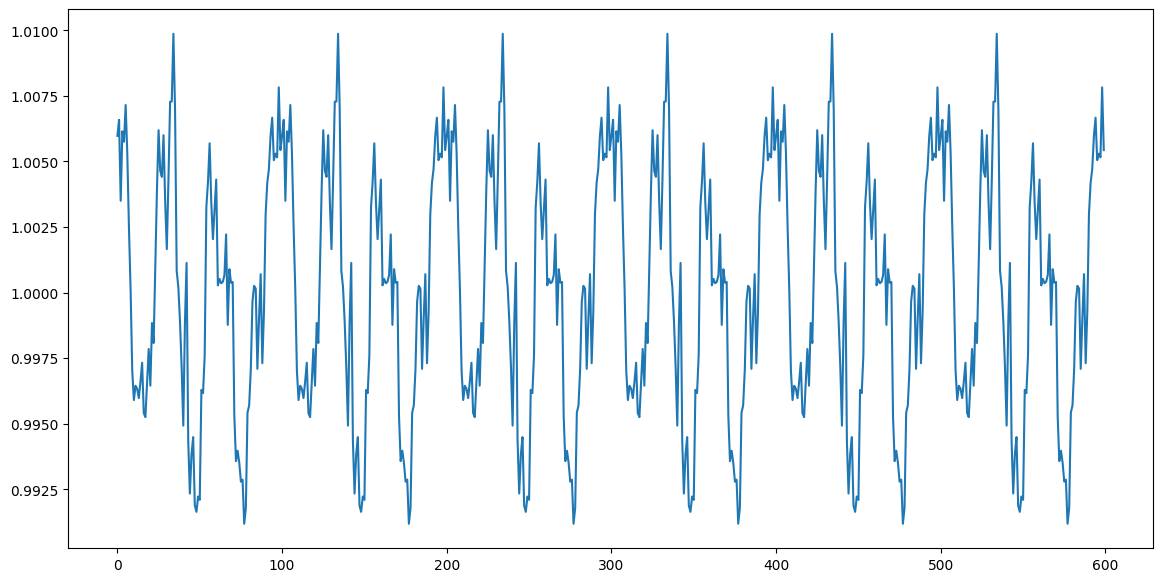

In [11]:
result.seasonal.iloc[:600].plot(figsize=(14, 7))

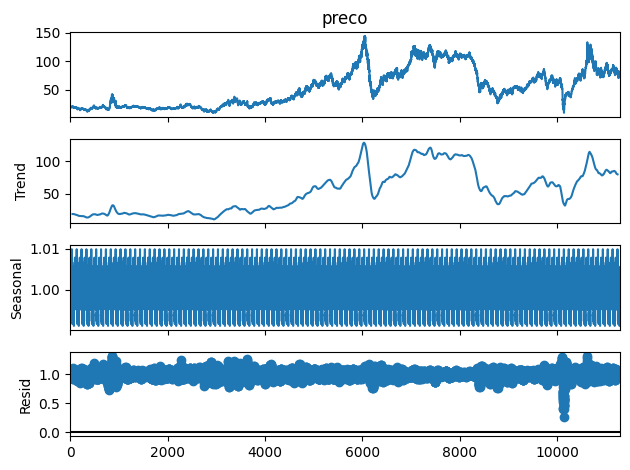

In [12]:
# Decomposição da série temporal
result = seasonal_decompose(dados_filtrados["preco"], model="multiplicative", period=100)
result.plot()
plt.show()

### Estatísticas Descritivas

In [13]:
# Estatísticas descritivas
dados_filtrados["preco"].describe()

,preco
count,11287.000000
mean,53.303132
std,33.169358
min,9.100000
25%,20.605000
50%,48.880000
75%,76.845000
max,143.950000


### Verificação de Dados Ausentes

In [14]:
# Verificação de dados ausentes

missing_values = dados_filtrados.isnull().sum()
missing_values

,0
data,0
preco,0


### Check de Estacionariedade (Teste de Dickey-Fuller Aumentado)

In [15]:
# Realizando o teste ADF
result = adfuller(dados_filtrados["preco"])

# Exibindo os resultados
print("Estatística ADF:", result[0])
print("p-valor:", result[1])
print("Número de lags usados:", result[2])
print("Número de observações:", result[3])
print("Valores críticos:")
for key, value in result[4].items():
    print(f'   {key}: {value}')

Estatística ADF: -2.1433801979673475
p-valor: 0.22743257275659406
Número de lags usados: 31
Número de observações: 11255
Valores críticos:
   1%: -3.4309311454511855
   5%: -2.861796834873785
   10%: -2.5669067080922225


Ou seja, a série é **não-estacionária**

## 3. Preparação dos Dados e Modelagem

### Dividindo os Dados em Treino e Teste

In [16]:
# Criando coluna preço dia anterior
dados_filtrados
dados_filtrados["preco_dia_anterior"] = dados_filtrados["preco"].shift(1)

print(dados_filtrados.head())

        data  preco  preco_dia_anterior
0 1987-05-20  18.63                 NaN
1 1987-05-21  18.45               18.63
2 1987-05-22  18.55               18.45
3 1987-05-25  18.60               18.55
4 1987-05-26  18.63               18.60


In [17]:
# Verificação de dados ausentes

missing_values = dados_filtrados.isnull().sum()
missing_values

,0
data,0
preco,0
preco_dia_anterior,1


In [18]:
dados_filtrados = dados_filtrados.drop(index=dados_filtrados.index[0])

In [19]:
dados_filtrados.head()

,data,preco,preco_dia_anterior
1,1987-05-21,18.45,18.63
2,1987-05-22,18.55,18.45
3,1987-05-25,18.60,18.55
4,1987-05-26,18.63,18.60
5,1987-05-27,18.60,18.63


In [20]:
# Dividindo em treino e teste

train_size = dados_filtrados.shape[0] - 7
train, test = dados_filtrados[0:train_size], dados_filtrados[train_size:]

# Converter a coluna de data para o formato datetime
train['data'] = pd.to_datetime(train['data'], format='%d/%m/%Y')

# Converter a coluna de data para o formato datetime
test['data'] = pd.to_datetime(test['data'], format='%d/%m/%Y')


In [21]:
print(train)

            data  preco  preco_dia_anterior
1     1987-05-21  18.45               18.63
2     1987-05-22  18.55               18.45
3     1987-05-25  18.60               18.55
4     1987-05-26  18.63               18.60
5     1987-05-27  18.60               18.63
...          ...    ...                 ...
11275 2024-10-11  80.27               79.45
11276 2024-10-12  78.47               80.27
11277 2024-10-15  73.68               78.47
11278 2024-10-16  73.65               73.68
11279 2024-10-17  74.37               73.65

[11279 rows x 3 columns]


<Axes: xlabel='data'>

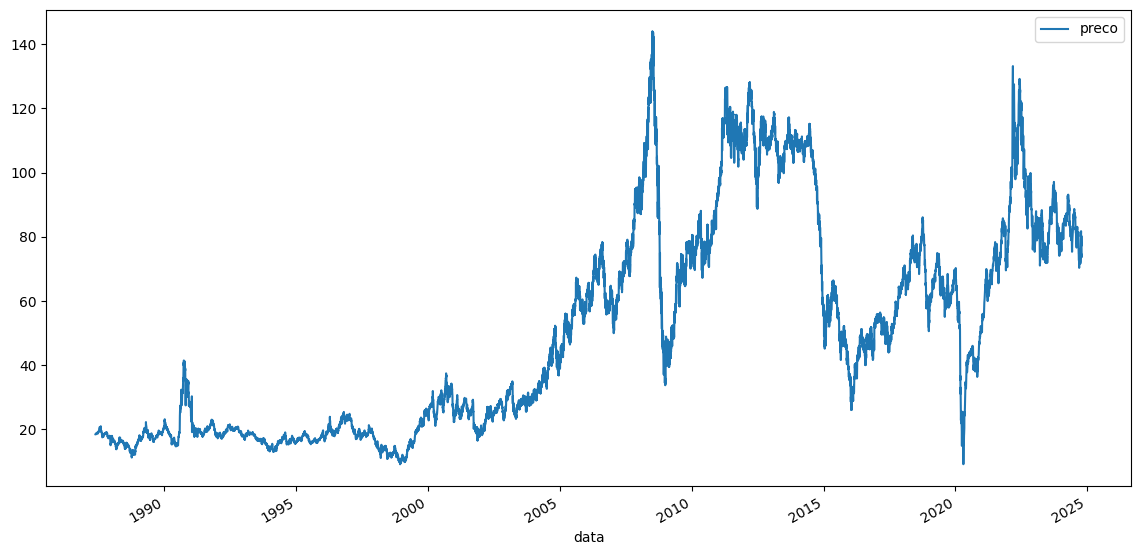

In [22]:
train.plot(x="data", y="preco", figsize=(14, 7))

In [23]:
print(test)

            data  preco  preco_dia_anterior
11280 2024-10-18  72.75               74.37
11281 2024-10-21  73.29               72.75
11282 2024-10-22  75.59               73.29
11283 2024-10-23  74.68               75.59
11284 2024-10-24  74.27               74.68
11285 2024-10-25  75.62               74.27
11286 2024-10-28  71.87               75.62


<Axes: xlabel='data'>

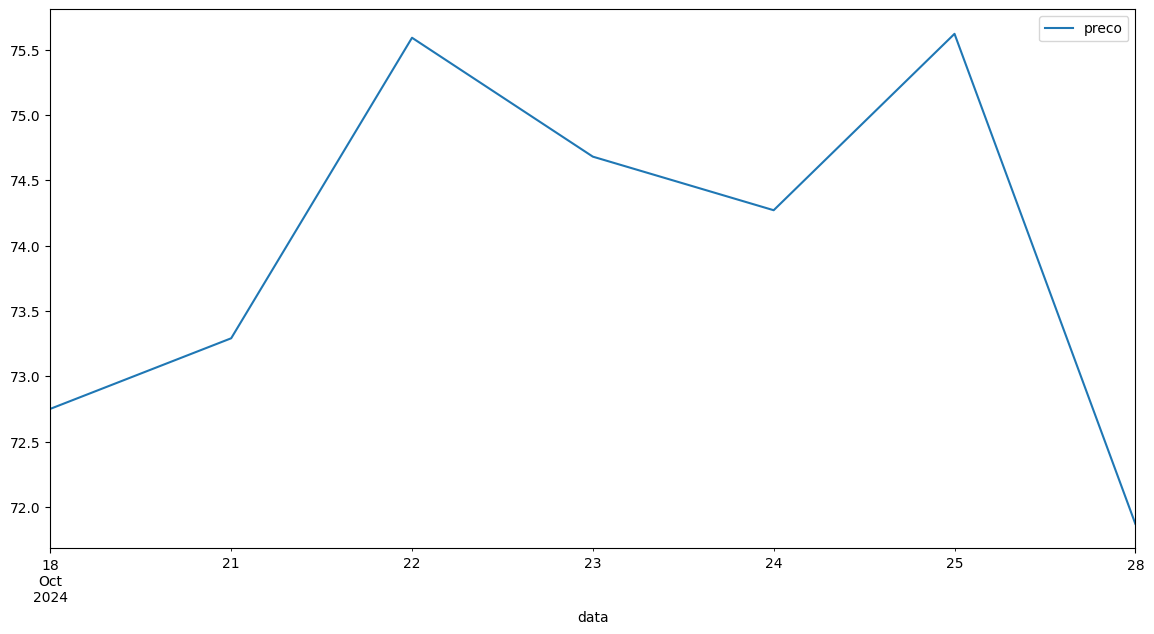

In [24]:
test.plot(x="data", y="preco", figsize=(14, 7))

### Modelo Arima

### Modelo Auto-Arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39728.632, Time=21.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40477.081, Time=0.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40299.274, Time=2.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40185.522, Time=3.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40475.212, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39889.703, Time=10.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39809.796, Time=7.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=39690.420, Time=18.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=39717.551, Time=13.66 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=39676.260, Time=19.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=39678.097, Time=13.68 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=39669.037, Time=65.77 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=39667.632, Time=59.84 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39678.247, Time=6.25 sec
 ARIMA(4,1,

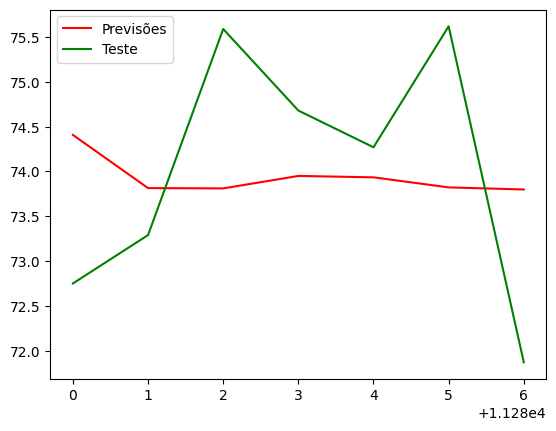

In [140]:
from pmdarima import auto_arima

# Ajuste do modelo Auto-ARIMA
modelo_auto = auto_arima(train["preco"],
                         seasonal=False,  # Use True se houver sazonalidade
                         stepwise=True,   # Para realizar a busca de forma eficiente
                         trace=True)      # Para exibir o progresso


# Fazer previsões
previsoes = modelo_auto.predict(n_periods=len(test))

print(previsoes)
# Comparar previsões com valores reais
mae = mean_absolute_error(test["preco"], previsoes)
mse = mean_squared_error(test["preco"], previsoes)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test["preco"] - previsoes) / test["preco"])) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Visualizar a série original, as previsões e o conjunto de teste

plt.plot(test["preco"].index, previsoes, label='Previsões', color='red')
plt.plot(test["preco"].index, test["preco"], label='Teste', color='green')
plt.legend()
plt.show()


In [ ]:
from pmdarima import auto_arima

# Ajuste do modelo Auto-ARIMA
modelo_auto = auto_arima(train["preco"],
                         seasonal=True,  # Use True se houver sazonalidade
                         stepwise=True,   # Para realizar a busca de forma eficiente
                         trace=True,
                         m = 10)      # Para exibir o progresso

# Resumo dos resultados
print(modelo_auto.summary())

# Fazer previsões
previsoes = modelo_auto.predict(n_periods=len(test))

# Comparar previsões com valores reais
mae = mean_absolute_error(test["preco"], previsoes)
mse = mean_squared_error(test["preco"], previsoes)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Visualizar a série original, as previsões e o conjunto de teste

plt.plot(test["preco"].index, previsoes, label='Previsões', color='red')
plt.plot(test["preco"].index, test["preco"], label='Teste', color='green')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=39726.755, Time=58.76 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=40477.081, Time=0.58 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=40294.213, Time=4.55 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=40181.597, Time=4.41 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=40475.212, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[10] intercept   : AIC=39726.433, Time=52.64 sec
 ARIMA(2,1,2)(0,0,0)[10] intercept   : AIC=39728.632, Time=13.20 sec
 ARIMA(2,1,2)(0,0,2)[10] intercept   : AIC=39728.024, Time=74.36 sec
 ARIMA(2,1,2)(1,0,0)[10] intercept   : AIC=39726.382, Time=30.15 sec
 ARIMA(2,1,2)(2,0,0)[10] intercept   : AIC=39727.971, Time=52.87 sec
 ARIMA(2,1,2)(2,0,1)[10] intercept   : AIC=39729.855, Time=53.02 sec
 ARIMA(1,1,2)(1,0,0)[10] intercept   : AIC=39887.838, Time=9.60 sec
 ARIMA(2,1,1)(1,0,0)[10] intercept   : AIC=39807.870, Time=14.68 sec
 ARIMA(3,1,2)(1,0,0)[10] intercept   : AIC=39688.976, Time=33.45 

### Modelo XGBoost

In [25]:
# Preparação dos dados para XGBoost
df = dados_filtrados
def create_features(df):
    df["Date"] = pd.to_datetime(df["data"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "preco_dia_anterior"]
TARGET = "preco"

# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 1.640541033063617
MSE: 4.226197964935059
MAPE: 2.2196863248807492


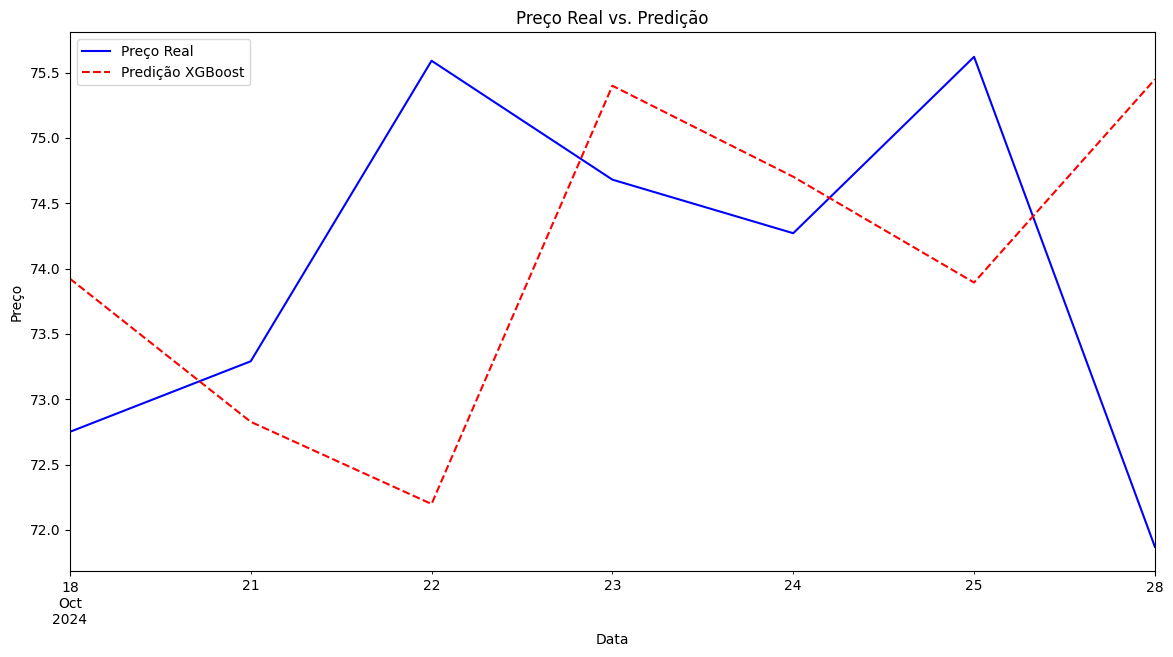

In [26]:
# Criando DataFrame com as previsões e datas correspondentes
predictions_df = test[['data']].iloc[-len(preds):].copy()  # Utilizando as últimas datas do conjunto de teste
predictions_df['predicao'] = preds

# Plotando o gráfico com os preços reais e as previsões
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar os dados reais
df[train_size:].plot(x="data", y="preco", ax=ax, label="Preço Real", color="blue")

# Plotar os dados de previsão
predictions_df.plot(x="data", y="predicao", ax=ax, label="Predição XGBoost", color="red", linestyle="--")

# Ajustando o gráfico
plt.title("Preço Real vs. Predição")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()

### Modelo Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektjquo/zbsng4gi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektjquo/93fq9flb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25897', 'data', 'file=/tmp/tmpzektjquo/zbsng4gi.json', 'init=/tmp/tmpzektjquo/93fq9flb.json', 'output', 'file=/tmp/tmpzektjquo/prophet_model1z3cdjlv/prophet_model-20241113185821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


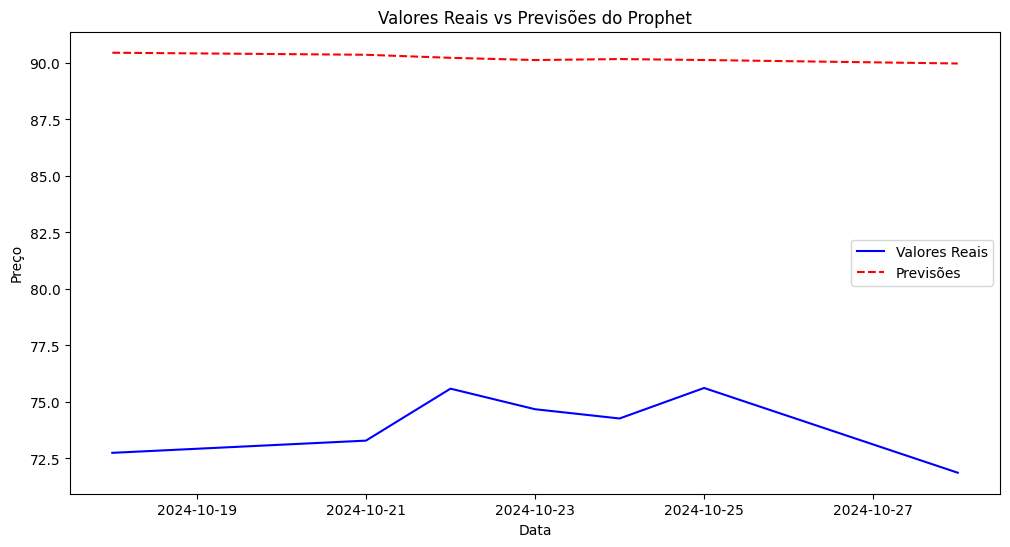

Prophet Metrics:
MAE: 16.19867107193298
MSE: 264.19744567605983
MAPE: 21.926573797746762


In [27]:
# Modelo Prophet
train_prophet = train.rename(columns={"data": "ds", "preco": "y"})
test_prophet = test.rename(columns={"data": "ds", "preco": "y"})

# Criar o modelo Prophet
model = Prophet(daily_seasonality=True)

# Treinar o modelo Prophet
model.fit(train_prophet)

# Criar o dataframe de datas futuras para prever (o período do conjunto de teste)
future = test_prophet[["ds"]]

# Fazer previsões
forecast = model.predict(future)

# Extrair apenas as previsões para o conjunto de teste
preds = forecast[["ds", "yhat"]].iloc[-len(test):]

# Plotar os valores reais e as previsões
plt.figure(figsize=(12, 6))
plt.plot(test_prophet[["ds"]], test_prophet[["y"]], label="Valores Reais", color="blue")
plt.plot(preds[["ds"]], preds["yhat"], label="Previsões", color="red", linestyle="--")

# Título e legendas
plt.title("Valores Reais vs Previsões do Prophet")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()

plt.show()

preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

### Modelo Prophet com Preço de Abertura

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektjquo/yurex58t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzektjquo/2pbfww9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16643', 'data', 'file=/tmp/tmpzektjquo/yurex58t.json', 'init=/tmp/tmpzektjquo/2pbfww9x.json', 'output', 'file=/tmp/tmpzektjquo/prophet_model_oy34w97/prophet_model-20241113185833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


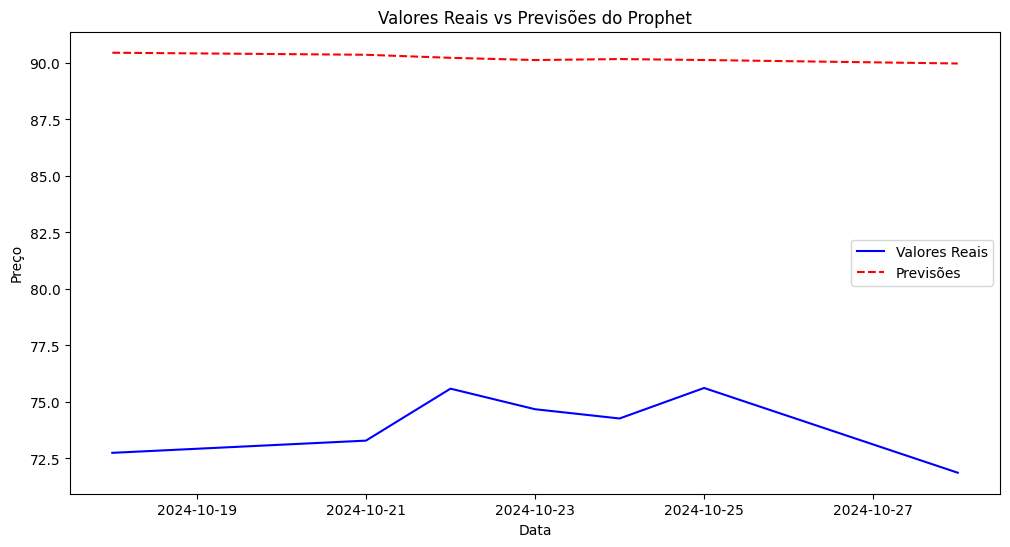

Prophet Metrics:
MAE: 16.19867107193298
MSE: 264.19744567605983
MAPE: 21.926573797746762


In [28]:
# Modelo Prophet
train_prophet_2 = train.rename(columns={"data": "ds", "preco": "y"})
test_prophet_2 = test.rename(columns={"data": "ds", "preco": "y"})

# Criar o modelo Prophet
model_2 = Prophet(daily_seasonality=True)

# Treinar o modelo Prophet
model_2.add_regressor("preco_dia_anterior")
model_2.fit(train_prophet_2)

# Criar o dataframe de datas futuras para prever (o período do conjunto de teste)
future_2 = test_prophet_2[["ds"]]

# Fazer previsões
future_2["preco_dia_anterior"] = pd.concat([train_prophet_2["preco_dia_anterior"], test_prophet_2["preco_dia_anterior"]], ignore_index=False)
forecast_2 = model.predict(future_2)

# Extrair apenas as previsões para o conjunto de teste
preds_2 = forecast_2[["ds", "yhat"]].iloc[-len(test):]


# Plotar os valores reais e as previsões
plt.figure(figsize=(12, 6))
plt.plot(test_prophet_2[["ds"]], test_prophet_2[["y"]], label="Valores Reais", color="blue")
plt.plot(preds_2[["ds"]], preds_2["yhat"], label="Previsões", color="red", linestyle="--")

# Título e legendas
plt.title("Valores Reais vs Previsões do Prophet")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()

plt.show()

preds_2 = preds_2.set_index("ds")
y_test_2 = test_prophet_2.set_index("ds")["y"]

metrics_pr_2 = calculate_metrics(y_test_2, preds_2["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr_2)

### Modelo SARIMAX

In [29]:
# Modelo SARIMAX
exog_train = train[["preco_dia_anterior"]]
exog_test = test[["preco_dia_anterior"]]


model = sm.tsa.statespace.SARIMAX(
    train["preco"], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean


metrics_sarimax = calculate_metrics(y_test, preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)


SARIMAX Metrics:
MAE: 1.230559603040561
MSE: 2.2858562227568164
MAPE: nan


<ipython-input-5-aa14772c6d8e>:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


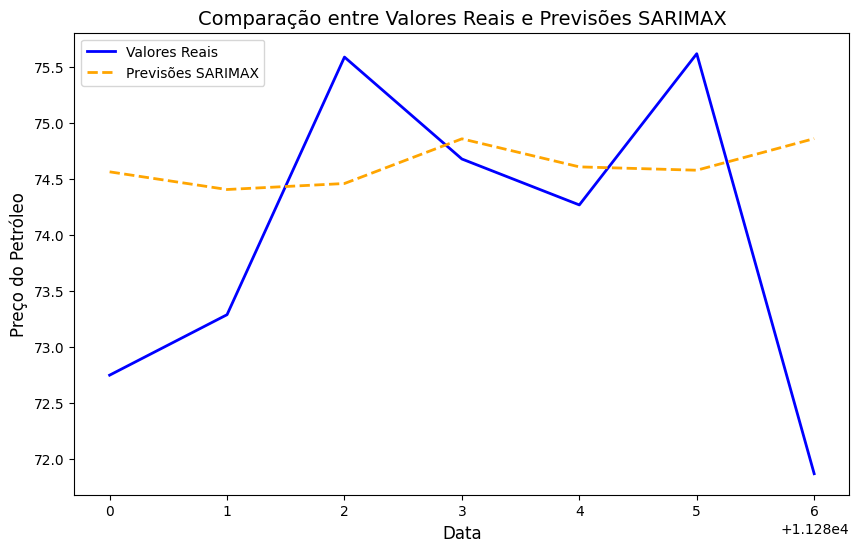

In [30]:
# Plotando os valores reais e preditos
plt.figure(figsize=(10, 6))

# Plotando os valores reais (dados de teste)
plt.plot(test.index, test["preco"], label="Valores Reais", color="blue", linewidth=2)

# Plotando as previsões (valores preditos)
plt.plot(test.index, preds, label="Previsões SARIMAX", color="orange", linestyle="--", linewidth=2)

# Adicionando título e rótulos aos eixos
plt.title("Comparação entre Valores Reais e Previsões SARIMAX", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço do Petróleo", fontsize=12)

# Adicionando a legenda para identificar as linhas
plt.legend()

# Exibindo o gráfico
plt.show()

# Comparando modelos

In [31]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)
df

,MAE,MSE,MAPE
XGBoost,1.640541,4.226198,2.219686
Prophet,16.198671,264.197446,21.926574
SARIMAX,1.230560,2.285856,NaN


## Conclusão

Neste notebook, realizamos uma análise detalhada dos preços do S&P 500. Após a análise exploratória, treinamos e avaliamos três modelos de séries temporais: XGBoost, Prophet e SARIMAX. As métricas de desempenho dos modelos foram calculadas para comparar sua eficácia na previsão dos preços de fechamento.